In [62]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
matplotlib.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

In [3]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

In [4]:
data.head()

Grant.Status Sponsor.Code Grant.Category.Code  \
0             1          21A                 50A   
1             1           4D                 10A   
2             0          NaN                 NaN   
3             0          51C                 20C   
4             0          24D                 30B   

  Contract.Value.Band...see.note.A  RFCD.Code.1  RFCD.Percentage.1  \
0                               A      230202.0               50.0   
1                               D      320801.0              100.0   
2                              NaN     320602.0               50.0   
3                               A      291503.0               60.0   
4                              NaN     380107.0              100.0   

   RFCD.Code.2  RFCD.Percentage.2  RFCD.Code.3  RFCD.Percentage.3  ...  \
0     230203.0               30.0     230204.0               20.0  ...   
1          0.0                0.0          0.0                0.0  ...   
2     321004.0               30.0     321015.0               20.0  ...   
3     321402.0               40.0          0.0                0.0  ...   
4          0.0                0.0          0.0                0.0  ...   

   Dept.No..1  Faculty.No..1  With.PHD.1  \
0      3098.0           31.0        Yes    
1      2553.0           25.0        Yes    
2      2813.0           25.0         NaN   
3      2553.0           25.0         NaN   
4      2923.0           25.0         NaN   

   No..of.Years.in.Uni.at.Time.of.Grant.1  Number.of.Successful.Grant.1  \
0                                >=0 to 5                           2.0   
1                                >=0 to 5                           3.0   
2                             Less than 0                           1.0   
3                            more than 15                           2.0   
4                             Less than 0                           0.0   

   Number.of.Unsuccessful.Grant.1  A..1  A.1  B.1  C.1  
0                             0.0   0.0  4.0  2.0  0.0  
1                             1.0   0.0  2.0  0.0  0.0  
2                             5.0   0.0  7.0  2.0  0.0  
3                             1.0   5.0  6.0  9.0  1.0  
4                             2.0   0.0  0.0  0.0  0.0  

[5 rows x 39 columns]

In [5]:
data.isnull().sum()

Grant.Status                                 0
Sponsor.Code                               613
Grant.Category.Code                        613
Contract.Value.Band...see.note.A          2461
RFCD.Code.1                                417
RFCD.Percentage.1                          417
RFCD.Code.2                                417
RFCD.Percentage.2                          417
RFCD.Code.3                                417
RFCD.Percentage.3                          417
RFCD.Code.4                                417
RFCD.Percentage.4                          417
RFCD.Code.5                                417
RFCD.Percentage.5                          417
SEO.Code.1                                 439
SEO.Percentage.1                           439
SEO.Code.2                                 439
SEO.Percentage.2                           439
SEO.Code.3                                 439
SEO.Percentage.3                           439
SEO.Code.4                                 439
SEO.Percentag

In [6]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Grant.Status                            6000 non-null   int64  
 1   Sponsor.Code                            5387 non-null   object 
 2   Grant.Category.Code                     5387 non-null   object 
 3   Contract.Value.Band...see.note.A        3539 non-null   object 
 4   RFCD.Code.1                             5583 non-null   float64
 5   RFCD.Percentage.1                       5583 non-null   float64
 6   RFCD.Code.2                             5583 non-null   float64
 7   RFCD.Percentage.2                       5583 non-null   float64
 8   RFCD.Code.3                             5583 non-null   float64
 9   RFCD.Percentage.3                       5583 non-null   float64
 10  RFCD.Code.4                             5583 non-null   floa

In [8]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull().values)[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

In [9]:
X_real_zeros = X[numeric_cols].fillna(0)

In [10]:
X_real_zeros.shape

(6000, 13)

In [11]:
X_real_mean = X[numeric_cols]
means = calculate_means(X[numeric_cols])
for item in X_real_mean.columns:
    X_real_mean[item].fillna(means[item], inplace=True)

In [12]:
X_real_mean.shape

(6000, 13)

In [13]:
X_cat = X[categorical_cols].applymap(str).fillna('NA')

In [14]:
X_cat.shape

(6000, 25)

In [15]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

categorial_data = pd.DataFrame({'sex': ['male', 'female', 'male', 'female'], 
                                'nationality': ['American', 'European', 'Asian', 'European']})
print('Исходные данные:\n')
print(categorial_data)
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(categorial_data.T.to_dict().values())
print('\nЗакодированные данные:\n')
print(encoded_data)

Исходные данные:

      sex nationality
0    male    American
1  female    European
2    male       Asian
3  female    European

Закодированные данные:

[[1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0.]]


In [16]:
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

In [17]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros,
X_test_real_zeros,
y_train, y_test) = train_test_split(X_real_zeros, y,
                                   test_size=0.3,
                                   random_state=0)
(X_train_real_mean,
X_test_real_mean) = train_test_split(X_real_mean,
                                   test_size=0.3,
                                   random_state=0)
(X_train_cat_oh,
X_test_cat_oh) = train_test_split(X_cat_oh,
                                   test_size=0.3,
                                   random_state=0)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

In [19]:
X_zeros_train = np.hstack((X_train_real_zeros, X_train_cat_oh))
X_zeros_test = np.hstack((X_test_real_zeros, X_test_cat_oh))
X_mean_train = np.hstack((X_train_real_mean, X_train_cat_oh))
X_mean_test = np.hstack((X_test_real_mean, X_test_cat_oh))

In [69]:
lr = LogisticRegression(random_state=0)
# lr.fit(X_zeros_train, y_train)
# y_zeros_pred = lr.predict(X_zeros_test)
optimizer = GridSearchCV(lr, param_grid, cv=cv)
optimizer.fit(X_zeros_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})

In [66]:
print(classification_report(y_test, y_zeros_pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       943
           1       0.73      0.72      0.73       857

    accuracy                           0.74      1800
   macro avg       0.74      0.74      0.74      1800
weighted avg       0.74      0.74      0.74      1800



{'C': 0.01}


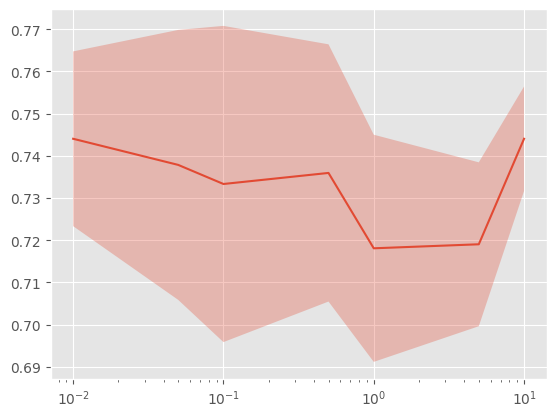

In [21]:
print(optimizer.best_params_)
plot_scores(optimizer)

In [73]:
roc_auc_score_zeros = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_zeros_test)[:, 1])
print(roc_auc_score_zeros)

0.8056223403794588


In [22]:
lr = LogisticRegression(random_state=0)
optimizer = GridSearchCV(lr, param_grid, cv=cv)
optimizer.fit(X_mean_train, y_train)

{'C': 0.01}


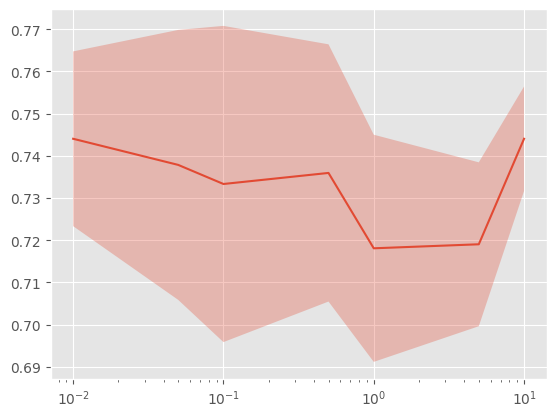

In [23]:
print(optimizer.best_params_)
plot_scores(optimizer)

In [74]:
roc_auc_score_mean = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_mean_test)[:, 1])
print(roc_auc_score_mean)

0.8080835140957567


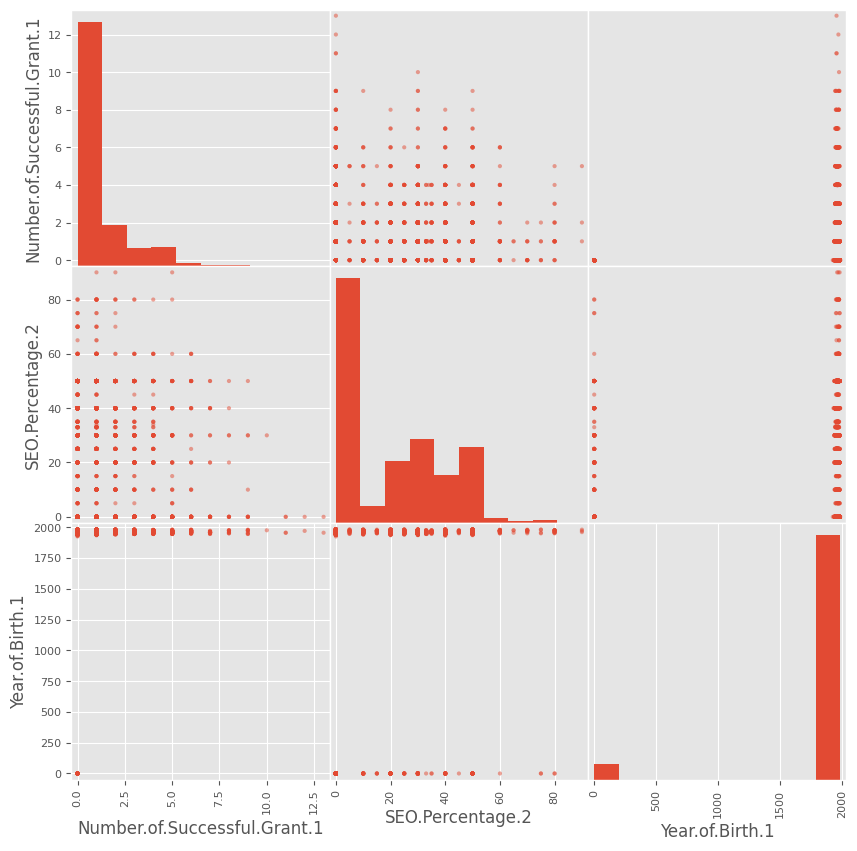

In [24]:
from pandas.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10,10))
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_real_scaled = scaler.fit_transform(X_train_real_zeros)
X_train_real_scaled = scaler.transform(X_train_real_scaled)

X_test_real_scaled = scaler.fit_transform(X_test_real_zeros)
X_test_real_scaled = scaler.transform(X_test_real_scaled)

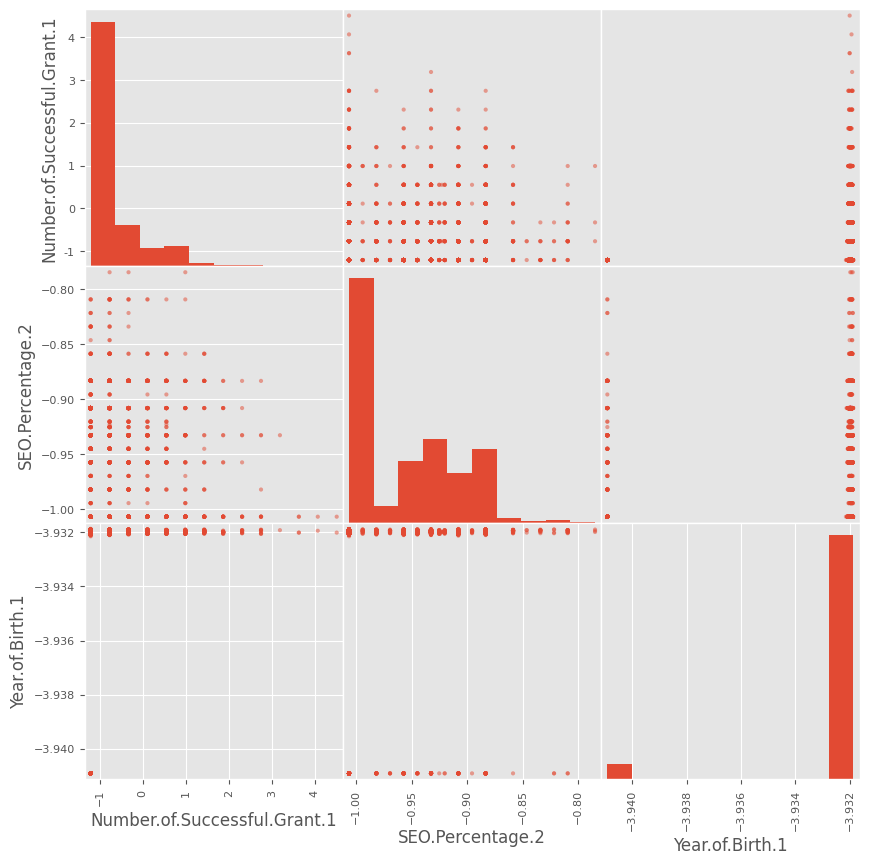

In [26]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

In [27]:
X_scaled_train = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_scaled_test = np.hstack((X_test_real_scaled, X_test_cat_oh))

In [28]:
lr = LogisticRegression(random_state=0)
optimizer = GridSearchCV(lr, param_grid, cv=cv)
optimizer.fit(X_scaled_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})

{'C': 0.1}


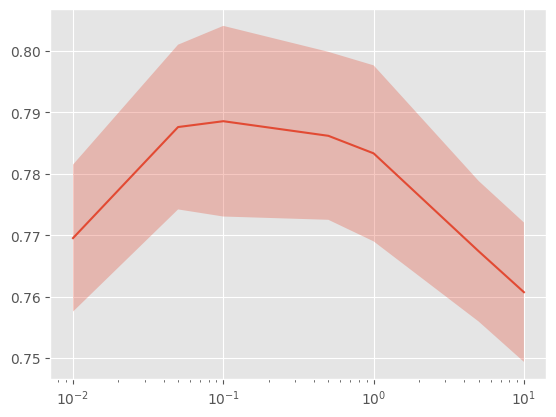

In [29]:
print(optimizer.best_params_)
plot_scores(optimizer)

In [75]:
roc_auc_score_scaled = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_scaled_test)[:, 1])
print(roc_auc_score_scaled)

0.8268894055690088


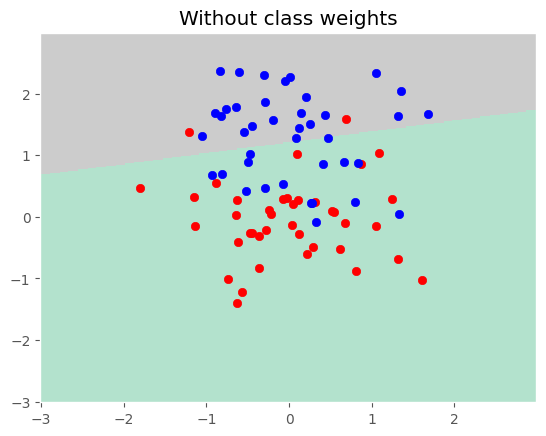

AUC: 0.911667


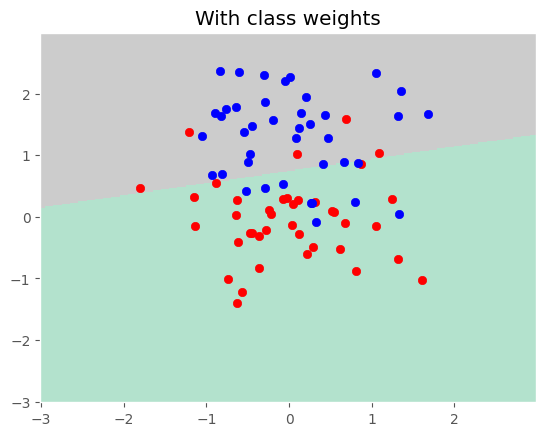

AUC: 0.906667


In [30]:
np.random.seed(0)
"""Сэмплируем данные из первой гауссианы"""
data_0 = np.random.multivariate_normal([0,0], [[0.5,0],[0,0.5]], size=40)
"""И из второй"""
data_1 = np.random.multivariate_normal([0,1], [[0.5,0],[0,0.5]], size=40)
"""На обучение берём 20 объектов из первого класса и 10 из второго"""
example_data_train = np.vstack([data_0[:20,:], data_1[:10,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((10))])
"""На тест - 20 из первого и 30 из второго"""
example_data_test = np.vstack([data_0[20:,:], data_1[10:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((30))])
"""Задаём координатную сетку, на которой будем вычислять область классификации"""
xx, yy = np.meshgrid(np.arange(-3, 3, 0.02), np.arange(-3, 3, 0.02))
"""Обучаем регрессию без балансировки по классам"""
optimizer = GridSearchCV(LogisticRegression(), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
"""Строим предсказания регрессии для сетки"""
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
"""Считаем AUC"""
auc_wo_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('Without class weights')
plt.show()
print('AUC: %f'%auc_wo_class_weights)
"""Для второй регрессии в LogisticRegression передаём параметр class_weight='balanced'"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_w_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC: %f'%auc_w_class_weights)

In [31]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


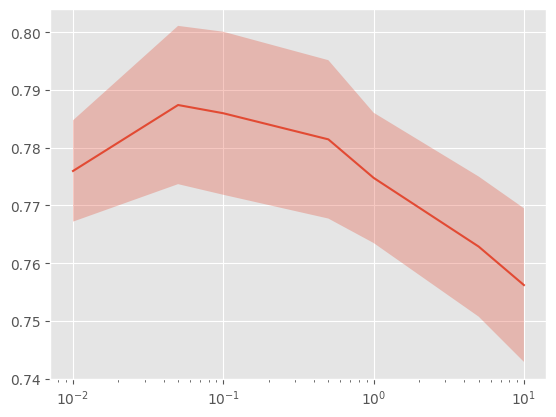

{'C': 0.05}


In [79]:
data_train = np.hstack((X_scaled_train, X_train_cat_oh))
data_test = np.hstack((X_scaled_test, X_test_cat_oh))
lr = LogisticRegression(random_state=0, class_weight='balanced')
optimizer = GridSearchCV(lr, param_grid, cv=cv)
optimizer.fit(data_train, y_train)
plot_scores(optimizer)
print(optimizer.best_params_)

In [80]:
roc_auc_score_ = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(data_test)[:, 1])
print(roc_auc_score_)

0.8841262338350135


In [84]:
np.random.seed(0)
count = np.sum(y_train==0)-np.sum(y_train==1)
indices_to_add = np.random.randint(np.sum(y_train==1), size = count)
X_train_to_add = data_train[y_train.values == 1,:][indices_to_add,:]
X_train_enhanced=np.append(data_train,X_train_to_add, axis=0)
y_train_enhanced=np.append(y_train,(np.ones((count,1))))

In [82]:
lr = LogisticRegression(random_state = 0, class_weight='balanced')
optimizer = GridSearchCV(lr, param_grid, cv=cv)
optimizer.fit(X_train_enhanced,y_train_enhanced)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=0),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})

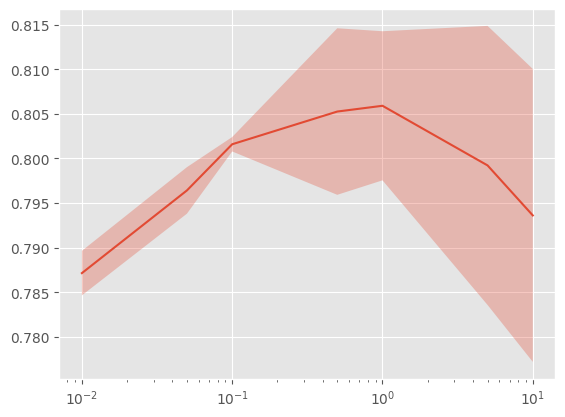

{'C': 1}

In [36]:
plot_scores(optimizer)
optimizer.best_params_

In [86]:
roc_auc_score_ = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(data_test)[:, 1])
print(roc_auc_score_)

0.8780073278384856


In [38]:
print('AUC ROC for classifier without weighted classes', auc_wo_class_weights)
print('AUC ROC for classifier with weighted classes: ', auc_w_class_weights)

AUC ROC for classifier without weighted classes 0.9116666666666666
AUC ROC for classifier with weighted classes:  0.9066666666666666


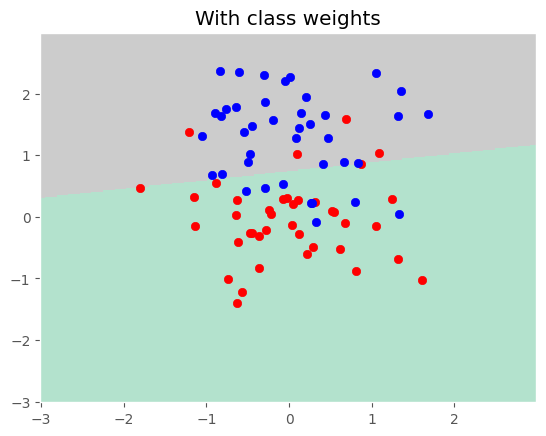

AUC ROC for stratified samples:  0.9125


In [39]:
"""Разделим данные по классам поровну между обучающей и тестовой выборками"""
example_data_train = np.vstack([data_0[:20,:], data_1[:20,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((20))])
example_data_test = np.vstack([data_0[20:,:], data_1[20:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((20))])
"""Обучим классификатор"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_stratified = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC ROC for stratified samples: ', auc_stratified)

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
(X_train_real_zeros_str, 
 X_test_real_zeros_str, 
 y_train_str, y_test_str) = train_test_split(X_real_zeros, y, 
                                             stratify=y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_cat_oh_str,
 X_test_cat_oh_str) = train_test_split(X_cat_oh,stratify=y,
                                   test_size=0.3, 
                                   random_state=0)

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_real_scaled_str=scaler.fit_transform(X_train_real_zeros_str)
X_test_real_scaled_str=scaler.transform(X_test_real_zeros_str)

In [43]:
dataZeros_train_str = np.hstack((X_train_real_scaled_str,X_train_cat_oh_str))
dataZeros_test_str = np.hstack((X_test_real_scaled_str,X_test_cat_oh_str))

In [44]:
lr = LogisticRegression(random_state=0, class_weight='balanced')
optimizer = GridSearchCV(lr, param_grid, cv=cv)
optimizer.fit(dataZeros_train_str,y_train_str)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=0),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})

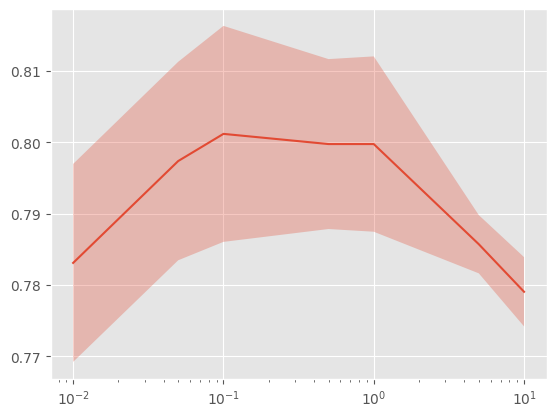

0.8794133964245021


In [45]:
plot_scores(optimizer)
print(roc_auc_score(y_test_str, optimizer.predict_proba(dataZeros_test_str)[:,1]))

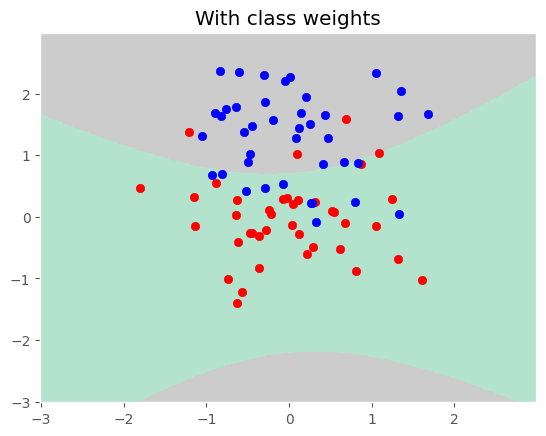

In [46]:
from sklearn.preprocessing import PolynomialFeatures

"""Инициализируем класс, который выполняет преобразование"""
transform = PolynomialFeatures(2)
"""Обучаем преобразование на обучающей выборке, применяем его к тестовой"""
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
"""Обращаем внимание на параметр fit_intercept=False"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('With class weights')
plt.show()

In [47]:
print(example_data_train_poly.shape)

(40, 6)


/home/todarenko.03/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/todarenko.03/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

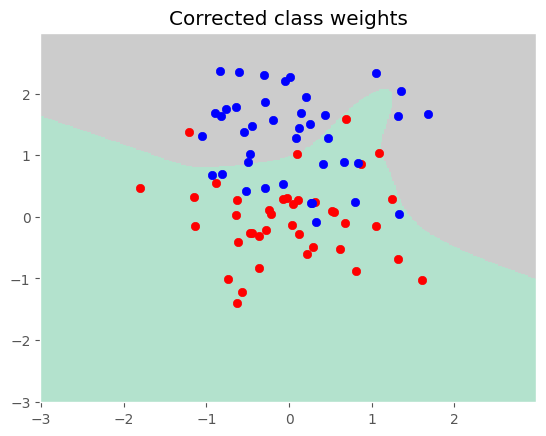

In [48]:
transform = PolynomialFeatures(11)
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('Corrected class weights')
plt.show()

In [49]:
print(example_data_train_poly.shape)

(40, 78)


In [50]:
(X_train_poly, 
 X_test_poly, 
 y_train_poly, y_test_poly) = train_test_split(X_real_zeros, y, 
                                             stratify=y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_cat_oh_poly,
 X_test_cat_oh_poly) = train_test_split(X_cat_oh, stratify=y,
                                   test_size=0.3, 
                                   random_state=0)

In [51]:
from sklearn.preprocessing import PolynomialFeatures
transform_str = PolynomialFeatures(2)
Data_train_poly = transform_str.fit_transform(X_train_poly)
Data_test_poly = transform_str.transform(X_test_poly)

In [52]:
scaler2 = StandardScaler()
X_train_poly_2 = scaler2.fit_transform(Data_train_poly)
X_test_poly_2=scaler2.transform(Data_test_poly)

In [53]:
dataZeros_train_poly = np.hstack((X_train_poly_2,X_train_cat_oh_poly))
dataZeros_test_poly = np.hstack((X_test_poly_2,X_test_cat_oh_poly))

In [54]:
lr = LogisticRegression(random_state = 0, class_weight='balanced', fit_intercept=False)
optimizer = GridSearchCV(lr, param_grid, cv=cv)
optimizer.fit(dataZeros_train_poly,y_train_poly)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          fit_intercept=False, random_state=0),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})

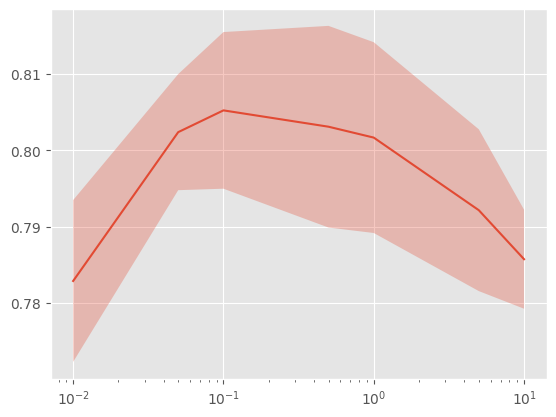

0.8869888147517899


In [55]:
plot_scores(optimizer)
print(roc_auc_score(y_test_poly, optimizer.predict_proba(dataZeros_test_poly)[:,1]))

In [56]:
(X_train_real_zeros_lasso, 
 X_test_real_zeros_lasso, 
 y_train_lasso, y_test_lasso) = train_test_split(X_real_zeros, y, 
                                             stratify=y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_cat_oh_lasso,
 X_test_cat_oh_lasso) = train_test_split(X_cat_oh, stratify=y,
                                   test_size=0.3, 
                                   random_state=0)

In [57]:
scaler = StandardScaler()
X_train_real_scaled_lasso=scaler.fit_transform(X_train_real_zeros_lasso)
X_test_real_scaled_lasso=scaler.transform(X_test_real_zeros_lasso)

In [58]:
dataZeros_train_lasso = np.hstack((X_train_real_scaled_lasso,X_train_cat_oh_str))
dataZeros_test_lasso = np.hstack((X_test_real_scaled_lasso,X_test_cat_oh_str))

In [59]:
lr=LogisticRegression(penalty='l2', random_state = 0, class_weight='balanced')
optimizer = GridSearchCV(lr, param_grid, cv=cv)
optimizer.fit(dataZeros_train_lasso,y_train_str)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=0),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})

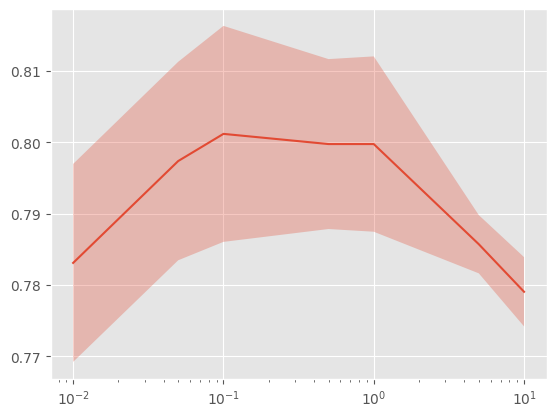

0.8794133964245021


In [60]:
plot_scores(optimizer)
print(roc_auc_score(y_test_str, optimizer.predict_proba(dataZeros_test_lasso)[:,1]))

In [61]:
optimizer.best_estimator_.coef_[0,:,]

array([ 0.01735657,  0.0316021 , -0.03719963, ...,  1.11284096,
        0.10266486, -0.10320504])